# Annual Mean Temperature Distribution
This looks at how surface temperature develops with time throughout the year

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp']  
# Load dataset
tau_lw = [1]
n_exp = len(tau_lw)

# # DEFAULT experiment
exp_dir = 'tau_sweep/aquaplanet/'
exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['simple_flux_lhe_calc']

lat_range = slice(25, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
except KeyError:
    w_atm_const = np.nan
try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name[0])['spectral_dynamics_nml']['reference_sea_level_press']/100

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

Removing height from var_keep


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
ds = ds_base[0].sel(pfull=p_surface_approx, method='nearest')
p_surface = float(ds.pfull)*100
sigma_near_surf = float(ds.pfull/p_surface_approx)
ds['rh'] = ds.sphum / sphum_sat(ds.temp, p_surface)
ds = annual_mean(ds).mean(dim='lon')
ds = ds.assign_coords(time=(ds.time - ds.time.min()).astype(int)).load()

In [5]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]
t_surf_spline_fit = [scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(t_surf[i], t_surf[i, 0]), bc_type='periodic') for i in range(n_lat)]
# t_surf_anom_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
#                                                        np.append(t_surf_anom, t_surf_anom[0]), bc_type='periodic')

def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_squared = (x_var-np.mean(x_var))**2
    return a + b*x_var + c*(x_anom_squared - np.mean(x_anom_squared))

def quartic_func(x_var, a, b, c, d, e):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_cubed = (x_var-np.mean(x_var))**3
    x_anom_fourth_power = (x_var-np.mean(x_var))**4
    return square_func(x_var, a, b, c) + d*(x_anom_cubed - np.mean(x_anom_cubed)) + \
        e*(x_anom_fourth_power-np.mean(x_anom_fourth_power))

def linear_func_shift(time, a, b, c, spline):
    x_var_shift = spline(time-c)
    return a + b*x_var_shift

## Obtaining Estimate of Amplitude and Phase of Actual Temperature Profile
Below, I smooth the temperature profile with a window of 20 days, and take the phase and amplitude of extrema from the resultant smoothed profile. These are indicated by the grey vertical lines, and differ slightly from the actual maxima and minima shown by the black solid lines.

I record the phase, as indicated by $\delta$, relative to the 1st harmonic of the insolation (shown by thick grey lines on left).

Below the example for a specific latitude, I plot the phase, $\delta$, and amplitude, $|T|$ for all latitudes. These are the values which we want to replicate, with a theoretical value.

In [6]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key))) for key in ['1', '2']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1', '2']}
for i in range(n_lat):
    for key in sw_amp_coefs:
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], n_time, int(key))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, n_time, sw_amp_coefs[key][i], np.zeros(int(key)))
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
time_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for i in range(n_lat):
    for key in time_extrema_temp:
        time_extrema_temp[key]['simulated'][i], spline_use = get_var_extrema_date(ds.time, t_surf_anom[i], smooth_window=smooth_ndays_temp_extrema, 
                                                                     type=key, max_extrema=1)
        amp_extrema_temp[key]['simulated'][i] = np.abs(spline_use(time_extrema_temp[key]['simulated'][i]))

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_92237/1660199413.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_extrema_temp[key]['simulated'][i], spline_use = get_var_extrema_date(ds.time, t_surf_anom[i], smooth_window=smooth_ndays_temp_extrema,


In [7]:
# General plotting info

plot_lat_ind = 4
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), 90]
color_approx = {'linear': 'k', 'quartic': default_colors[3], '1_harmonic': default_colors[1], 'linear_approx': 'k', 
                'linear_shift': default_colors[0], 'linear_shift_0': 'k', 'linear_shift_approx': default_colors[0], 
                'square': default_colors[2], 'square_approx': default_colors[2], 'square_0': 'k', 
                'final': 'purple'}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'linear': ':', 'quartic': ':', '1_harmonic': '-', 'linear_shift': '-', 'linear_shift_0': ':', 'linear_shift_approx': ':', 
                    'square': '-', 'square_approx': ':', 'square_0': ':', 'final': '-'}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx: np.max(np.abs(x - x_approx), axis=1), 
                   'median': lambda x, x_approx: np.median(np.abs(x - x_approx), axis=1), 
                   'mean': lambda x, x_approx: np.mean(np.abs(x - x_approx), axis=1)}
error_func_use = 'median'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

In [8]:
fig_sw_temp_sl, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')
ax[0].plot(ds.time, sw_fourier_fit['2'][plot_lat_ind], color='grey', 
           alpha=0.5, lw=2.5, label='2 Harmonics')

ax[1].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds.swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    ax[1].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
ax[1].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days", fontsize=8, y=0.93)
plt.close()

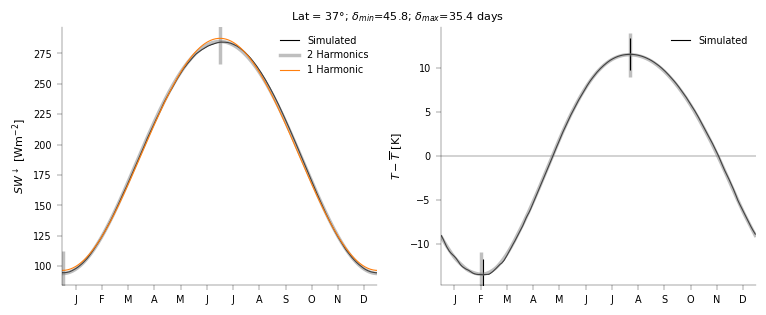

In [9]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)

ax[1].lines[0].set_ydata(t_surf_anom[plot_lat_ind])         # change y values of black line so actual not smoothed line
ax[1].plot(ds.time, scipy.ndimage.convolve1d(t_surf_anom[plot_lat_ind], np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, 
                                             mode='wrap'), color='grey', lw=2.5, alpha=0.5)
ax[0].plot(ds.time, sw_fourier_fit['1'][plot_lat_ind], color=color_approx['1_harmonic'],
           linestyle=linestyle_approx['1_harmonic'], label='1 Harmonic')
ax[1].scatter(ds.time[t_surf_anom[plot_lat_ind].argmin()], t_surf_anom[plot_lat_ind].min(),
                   color='k', marker='|', s=500)
ax[1].scatter(ds.time[t_surf_anom[plot_lat_ind].argmax()], t_surf_anom[plot_lat_ind].max(),
                   color='k', marker='|', s=500)
ax[0].legend()
fig

Text(0.5, 0.05, 'Latitude [deg]')

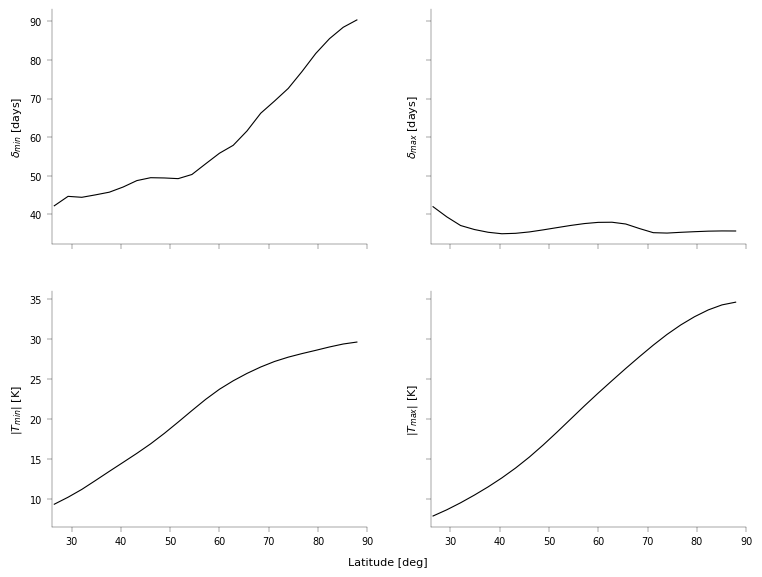

In [10]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    ax[0, i].plot(ds.lat, time_extrema_temp[key]['simulated'] - time_extrema_sw[key], color='k', label='Simulated')
    ax[1, i].plot(ds.lat, amp_extrema_temp[key]['simulated'], color='k')
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05)

## Linear Surface Budget
The surface energy budget is $C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$
 
As we saw above, a Fourier representation, $SW^{\downarrow}(t) \approx F_0 + F_1\cos(2\pi ft) + \frac{F_2}{F_1}F_1\cos(4\pi ft)$ works well (second term is only included if there are two harmonics).

Given this, if we can represent $\Gamma^{\uparrow}(t) = (LW^{\uparrow} - LW^{\downarrow}) + LH^{\uparrow} + SH^{\uparrow} \approx \lambda_0 + \lambda T(t)$, then a Fourier solution for $T(t)$ with the same number of harmonics as $SW^{\downarrow}$ is possible:

$T(t) = \frac{T_0}{2} + \sum_{n=1}^{N} T_n\cos(2n\pi ft - \phi_n)$

Below, we look at how accurate this approximation is.

A comparison to the *best* possible approximation with just temperature is shown, via the quartic approximation:

$\Gamma^{\uparrow}(t) \approx \lambda_0 + \lambda_1 T(t) + \lambda_2 (T'^2 - \overline{T'^2}) + \lambda_3 (T'^3 - \overline{T'^3}) + 
\lambda_4(T'^4 - \overline{T'^4})$

where $T' = T-\overline{T}$ is the temperature anomaly.

In [11]:
gamma_up = np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()
gamma_params = {'linear': np.zeros((n_lat, 2)), 'quartic': np.zeros((n_lat, 5))}
gamma_approx = {'linear': np.zeros((n_lat, n_time)), 'quartic': np.zeros((n_lat, n_time))}
gamma_params0 = [-800, 4]
for i in range(n_lat):
    gamma_params['linear'][i] = optimize.curve_fit(linear_func, t_surf[i], gamma_up[i], p0=gamma_params0)[0]
    gamma_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf[i], gamma_up[i], p0=gamma_params0 + [0, 0, 0])[0]
    gamma_approx['linear'][i] = linear_func(t_surf[i], *gamma_params['linear'][i])
    gamma_approx['quartic'][i] = quartic_func(t_surf[i], *gamma_params['quartic'][i])

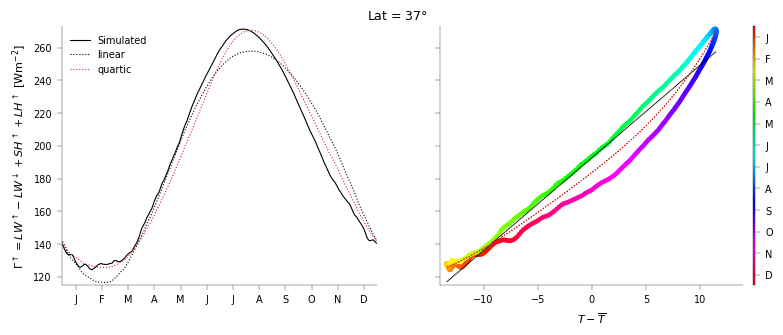

In [12]:
fig, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(gamma_up[plot_lat_ind]), color='k', label='Simulated')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma_up[plot_lat_ind]), c=ds.time, cmap='hsv')
for key in ['linear', 'quartic']:
    ax[0].plot(ds.time, gamma_approx[key][plot_lat_ind], 
               color=color_approx[key], linestyle=linestyle_approx[key], label=key.lower())
    ax[1].plot(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma_approx[key][plot_lat_ind]), 
               color=color_approx[key], linestyle=linestyle_approx[key], label=key.lower())

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
ax[1].set_ylim(np.floor(gamma_up[plot_lat_ind].min()), np.ceil(gamma_up[plot_lat_ind].max()))
ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$", fontsize=9, y=0.93);

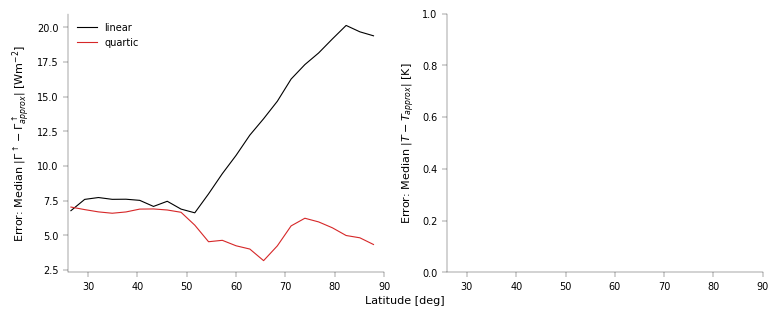

In [13]:
fig_error, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for key in ['linear', 'quartic']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma_up), gamma_approx[key]), color=color_approx[key],
               label=key)
ax[0].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error.supxlabel('Latitude [deg]', fontsize=8);

### Problem with 1 Harmonic

Below we see that with 1 harmonic, the phasing and amplitude of the maxima and minima are constrained to be the same. But clearly we do not see this in the actual data.

As a comparison, I include a numerical solution obtained with a quartic approximation for $\Gamma^{\uparrow}$ and with 5 harmonics of temperature as an indicator of the *best* we can possibly do.

Allowing for two harmonics, with this linear $\Gamma$ approximation does almost as well as the quartic approximation in terms of the phasing and amplitude of the maxima. It not allows for asymmetry.

In [14]:
day_seconds = 86400
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
def get_x_from_lambda(lambda_const, heat_capacity=heat_capacity, f=1/360, day_seconds=day_seconds):
    return 2*np.pi*f/day_seconds*heat_capacity/lambda_const

quartic_n_harmonics = 5
temp_approx = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', 'quartic', 'linear']}
for i in tqdm(range(n_lat)):
    temp_approx['1_harmonic'][i] = get_temp_fourier(ds.time, sw_fourier_fit['1'][i], heat_capacity, gamma_params['linear'][i], n_harmonics=1)[0]
    temp_approx['linear'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['linear'][i])[0]
    # For quartic allow 5 harmonic for temperature, but use 2 harmonic SW approximation, to allow more direct comparison
    try:
        temp_approx['quartic'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['quartic'][i][:2], 
                                                     lambda_nl=gamma_params['quartic'][i][2:], numerical=True, n_harmonics=quartic_n_harmonics)[0]
    except ValueError:
        warnings.warn('quartic fit not working')
        
for key in temp_approx:
    if '1_harmonic' in key:
        # Use analytical solution for 1 harmonic so as to make value a float, more accurate
        time_extrema_temp['min'][key] = np.arctan(get_x_from_lambda(gamma_params['linear'][:, 1], heat_capacity))/(2*np.pi)*360
        time_extrema_temp['max'][key] = time_extrema_temp['min'][key]+360/2
        amp_extrema_temp['min'][key] = np.abs(sw_amp_coefs['1'][:, 1]/gamma_params['linear'][:, 1]/np.sqrt(
            1+get_x_from_lambda(gamma_params['linear'][:, 1], heat_capacity)**2))
        amp_extrema_temp['max'][key] = amp_extrema_temp['min'][key]
    else:
        time_extrema_temp['min'][key] = ds.time[temp_approx[key].argmin(axis=1)].to_numpy()
        time_extrema_temp['max'][key] = ds.time[temp_approx[key].argmax(axis=1)].to_numpy()
        amp_extrema_temp['min'][key] = temp_approx[key].mean(axis=1) - temp_approx[key].min(axis=1)
        amp_extrema_temp['max'][key] = temp_approx[key].max(axis=1) - temp_approx[key].mean(axis=1)

100%|██████████| 23/23 [00:11<00:00,  1.96it/s]


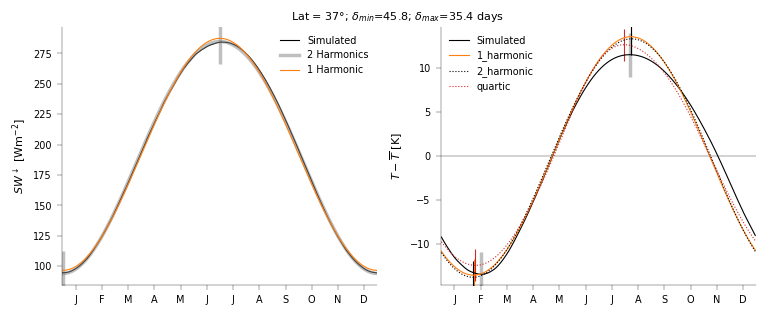

In [15]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1'][plot_lat_ind], color=color_approx['1_harmonic'],
           linestyle=linestyle_approx['1_harmonic'], label='1 Harmonic')
for key2 in ['1_harmonic', 'linear', 'quartic']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')

for key in time_extrema_sw:
    for key2 in ['1_harmonic', 'linear', 'quartic']:
        ax[1].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500)
ax[0].legend()
ax[1].legend()
fig

### Theory for Amplitude and Phasing
We know the single harmonic analytic solution has an issue that the phasing and amplitude of maxima and minima are forced to be the same.

The analytic two harmonic solution on the other hand, overcomes this problem. A relatively simple equation can be derived for the phasing and amplitude of the second harmonic assuming the extrema are near the extrema of the first harmonic. This is shown by the crosses below, and qualitatively explains why at high latitudes, the minima (maxima) occur later (earlier) than predicted from the first harmonic, 
and the amplitude is less (more) than that of the 1st harmonic.

This assumes $|\sin(2\pi f\Delta_{max})| << 1$, where $\Delta_{max}$ is the time difference between 1 harmonic and 2 harmonic maxima. Thus it breaks down at high latitudes for the minima, where $\Delta_{max} > 20$ days.

In [16]:
def get_extrema_amp_time_approx(sw_amp1, sw_amp2, lambda_const, heat_capacity, lambda_r=0, Lambda_r=0, lambda_sq=0,
                                type='max', n_day_year=360, day_seconds: float = day_seconds):
    f = 1/(n_day_year*day_seconds)

    # Modifications to deal with rh phase case
    heat_capacity = heat_capacity - lambda_r * Lambda_r*day_seconds
    lambda_tot = lambda_const + lambda_r - 2 * np.pi**2 * lambda_r * (Lambda_r/n_day_year)**2

    x = 2*np.pi*f*heat_capacity/lambda_tot

    a = sw_amp1/lambda_tot/np.sqrt(1+x**2)
    b = sw_amp2/lambda_tot/(1+x**2)/(1+4*x**2)
    coef_b1 = 1+3*x**2
    coef_b2 = 2*x**3

    # Modifications to deal with squared term - different lambda_tot and heat capacity for 2nd harmonic
    # Need to change b, coef_b1 and coef_b2
    if lambda_sq == 0 or sw_amp2 == 0:
        sq_param = 0
    else:
        sq_param = 0.5 * lambda_sq * sw_amp1**2 / (lambda_tot**2 * sw_amp2)/(1+x**2)**2
    f_beta = 1 - sq_param*(1+4*x**2)/(1-sq_param+5*sq_param*x**2)
    lambda_tot_harmonic2 = (1+f_beta*4*x**2)/(1+f_beta**2*4*x**2)/(1+sq_param*(x**2-1)) * lambda_tot
    b = b * (1+4*x**2)/(1+4*f_beta**2*x**2) * lambda_tot / lambda_tot_harmonic2
    coef_b1 = coef_b1 * (1 + (4*f_beta-1)*x**2) / (1+3*x**2)
    coef_b2 = coef_b2 * (f_beta*x**2+1-f_beta) / x**2


    if (sw_amp1>0 and type.lower() == 'max') or (sw_amp1<0 and type.lower() == 'min'):
        amp_extrema1 = a
        t_extrema1 = np.arctan(x)/(2*np.pi*f)/day_seconds               # timing of 1st harmonic extrema
    else:
        amp_extrema1 = -a
        t_extrema1 = (np.arctan(x)+np.pi)/(2*np.pi*f)/day_seconds               # timing of 1st harmonic extrema
    ba_ratio = b/amp_extrema1
    if ba_ratio == 0:
        sin_t_extrema_mod = 0
    else:
        y0 = -2*coef_b2*ba_ratio/(1+4*coef_b1*ba_ratio)
        sin_t_extrema_mod = (-1 + (1+8*y0**2)**0.5)/(4*y0)
    t_extrema_mod = np.arcsin(sin_t_extrema_mod)/(2*np.pi*f)/day_seconds
    amp_extrema_scale = 1 + coef_b1*ba_ratio - 2*coef_b2*ba_ratio*sin_t_extrema_mod - 0.5*(1+coef_b1*ba_ratio)*sin_t_extrema_mod**2
    info_dict = {'t_extrema1': t_extrema1, 't_extrema_mod': t_extrema_mod, 'amp_extrema1': amp_extrema1, 'amp_extrema_scale': amp_extrema_scale}
    return t_extrema1+t_extrema_mod, amp_extrema1 * amp_extrema_scale, info_dict
# i=-1
# get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['square'][i, 1], heat_capacity,
#                                             lambda_sq=gamma_params['square'][i, 2],  type=key)[:2]

for key in time_extrema_temp:
    time_extrema_temp[key]['linear_taylor_calc'] = np.zeros(n_lat)
    amp_extrema_temp[key]['linear_taylor_calc'] = np.zeros(n_lat)
    for i in range(n_lat):
        time_extrema_temp[key]['linear_taylor_calc'][i], amp_extrema_temp[key]['linear_taylor_calc'][i] = \
            get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['linear'][i][1], heat_capacity, type=key)[:2]
amp_extrema_temp['min']['linear_taylor_calc'] = np.abs(amp_extrema_temp['min']['linear_taylor_calc'])
# plt.plot(ds.lat, amp_extrema_temp['min']['1_harmonic'], color=default_colors[1])   
# plt.plot(ds.lat, amp_extrema_temp['min']['linear'], color='k')    

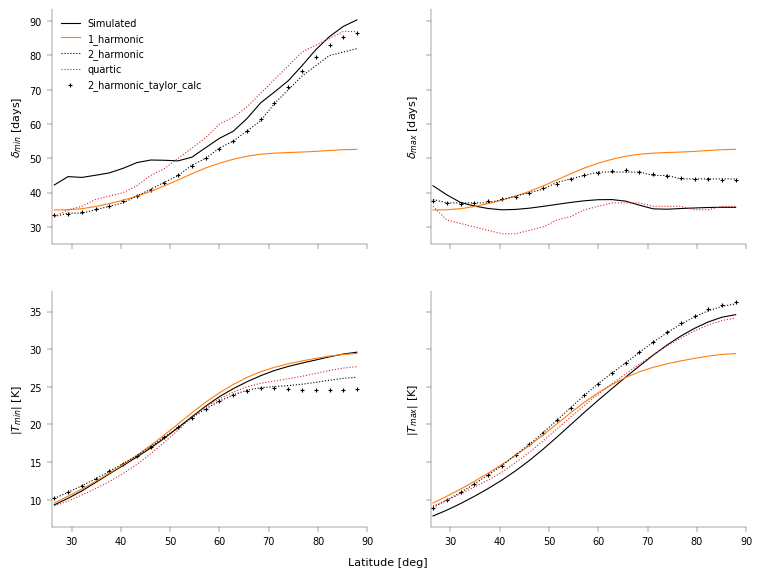

In [17]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear', 'quartic']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], color=color_approx['linear'], marker='+',
                     label='2_harmonic_taylor_calc')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
ax[0, 0].legend()
fig

## Extension beyond 2 Harmonics - Relative Humidity Phasing
Below, we see that the 2 harmonic analytic solution for $T$ with linear $\Gamma^{\uparrow}$ is almost as good as the quartic solution. It is significantly worse at latitudes where the approximation for $\Gamma^{\uparrow}$ itself breaks down. 

So, to further improve our temperature theory, we need a better approximation for $\Gamma^{\uparrow}$.

The blue line includes a phase shift for relative humidity, and is clearly important for low latitudes. It actually does better than the quartic solution.

In [18]:
try: 
    lh_rh_prefactor = -L_v * w_atm_const * ds.drag_q.mean(dim='time') * get_density(ds.temp.mean(dim='time'), ds.pfull*100) * \
                      sphum_sat(ds.temp.mean(dim='time'), ds.pfull*100)
except AttributeError:
    lh_rh_prefactor = -np.full(n_lat, 10)
lh_rh_cont = lh_rh_prefactor * (ds.rh - ds.rh.mean(dim='time'))
if lh_rh_cont.shape[0] == 360:
    lh_rh_cont = lh_rh_cont.T
lh_rh_cont_params = np.zeros((n_lat, 3))
gamma_params['linear_shift'] = np.zeros((n_lat, 4))     # lambda_0, lambda, lambda_r, Lambda_r
gamma_approx['linear_shift'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit[i])
    lh_rh_cont_params[i] = optimize.curve_fit(fit_func_use, ds.time, 
                                                         lh_rh_cont[i], p0=[50, -1, 0])[0]
    gamma_approx['linear_shift'][i] = linear_func_shift(ds.time, *lh_rh_cont_params[i], t_surf_spline_fit[i])
    gamma_params['linear_shift'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], 
                                                         gamma_up[i] - lh_rh_cont[i], p0=gamma_params0)[0]
    gamma_approx['linear_shift'][i] = gamma_approx['linear_shift'][i] + linear_func(t_surf[i], *gamma_params['linear_shift'][i, :2])
# Add phase parameters to full lambda
gamma_params['linear_shift'][:, 0] = gamma_params['linear_shift'][:, 0] + lh_rh_cont_params[:, 0]
gamma_params['linear_shift'][:, 2:] = lh_rh_cont_params[:, 1:]

temp_approx['linear_shift'] = np.zeros((n_lat, n_time))
temp_approx['linear_shift_0'] = np.zeros((n_lat, n_time))          # same as lambda_shift but set phase factor to 0
for i in range(n_lat):
    temp_approx['linear_shift'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['linear_shift'][i, :3], 
                                                      np.asarray([0, gamma_params['linear_shift'][i, 3]]))[0]
    temp_approx['linear_shift_0'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['linear_shift'][i, :3], 
                                                      )[0]

for key2 in ['linear_shift', 'linear_shift_0']:
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)

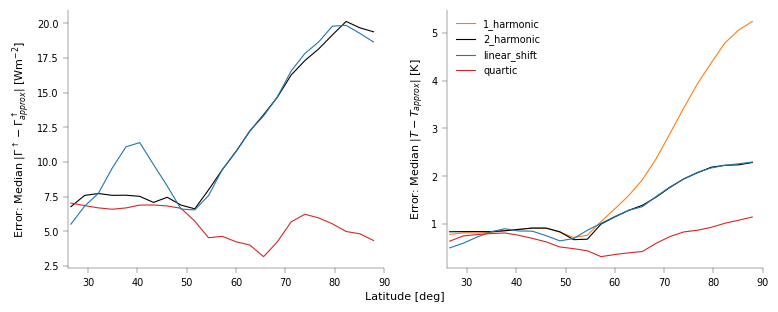

In [19]:
fig = copy.deepcopy(fig_error)
ax = fig.axes
for key in ['1_harmonic', 'linear', 'linear_shift', 'quartic']:
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key] - 
                                  np.mean(temp_approx[key], axis=1)[:, np.newaxis]), color=color_approx[key], 
               label=key if key != 'linear' else '2_harmonic')
ax[0].plot(ds.lat, error_func(smooth_func(gamma_up), gamma_approx['linear_shift']), color=color_approx['linear_shift'], 
               label=key if key != 'linear' else '2_harmonic')
ax[1].legend()
ax[0].get_legend().remove()
fig

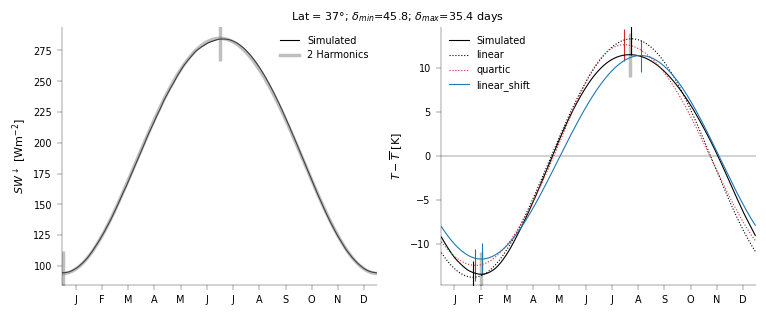

In [20]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
for key2 in ['linear', 'quartic', 'linear_shift']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)

for key in time_extrema_sw:
    for key2 in ['linear', 'quartic', 'linear_shift']:
        ax[1].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500)
ax[0].legend()
ax[1].legend()
fig

### Effect on Extrema Phase and Amplitude
Below, we see that the effect of the relative phasing of relative humidity is to push both extrema later in the year, and make the amplitude smaller (compared to linear dotted black line). This acts to improve the comparison to the simulated (solid black line) at low latitudes.

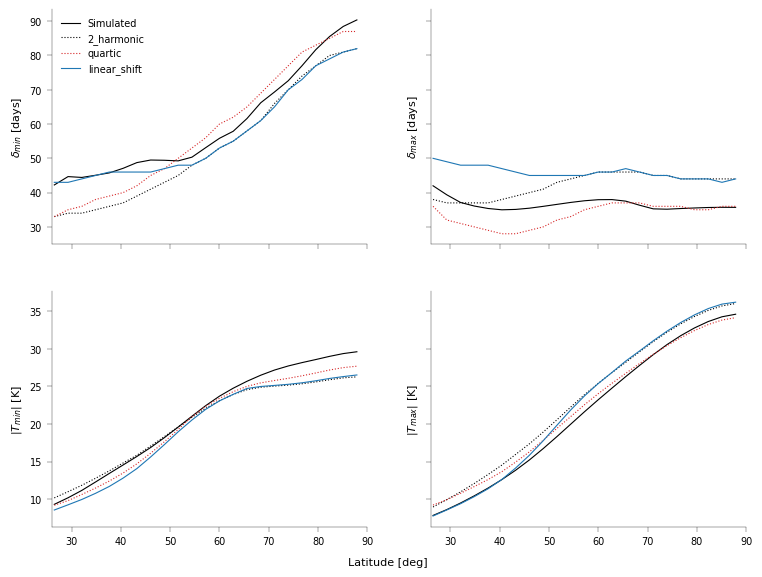

In [21]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['linear', 'quartic', 'linear_shift']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
ax[0, 0].legend()
fig

### Quantifying the effect of including phase, $\Lambda_r$, in terms of heat capacity, $C$, and temperature feedback, $\lambda$
Above we saw the effect of relative humidity phasing is to push extrema later in the year, and reduce their amplitude.

We would like to explain this in terms of modifications to heat capacity, $C$, and temperature feedback parameter, $\lambda$.

An increase to $C$ pushes the extrema later (more ocean like), and reduces the amplitude.
An increase to $\lambda$ makes extrema occur earlier and reduces the amplitude.

The approximation (blue dotted line) below uses modified $C_{mod}<C$ and $\lambda_{mod}<\lambda$ and then the linear solution for $T(t)$ with these modified parameters. It clearly does very well.

In [22]:
for key2 in ['linear_shift_approx']:
    temp_approx[key2] = np.zeros((n_lat, n_time))
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
        time_extrema_temp[key]['linear_shift_taylor_calc'] = np.zeros(n_lat)
        amp_extrema_temp[key]['linear_shift_taylor_calc'] = np.zeros(n_lat)
        time_extrema_temp[key]['linear_shift_0_taylor_calc'] = np.zeros(n_lat)
        amp_extrema_temp[key]['linear_shift_0_taylor_calc'] = np.zeros(n_lat)
        
    for i in range(n_lat):
        heat_capacity_mod = heat_capacity - gamma_params['linear_shift'][i, 2]*gamma_params['linear_shift'][i, 3]*day_seconds
        lambda_const_mod = gamma_params['linear_shift'][i][1]+gamma_params['linear_shift'][i][2] - \
                           2*np.pi**2*(gamma_params['linear_shift'][i, 3]/360)**2 * gamma_params['linear_shift'][i, 2]
        temp_approx[key2][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity_mod, 
                                                                 np.asarray([gamma_params['linear_shift'][i, 0], lambda_const_mod]))[0]
        for key in time_extrema_temp:
            time_extrema_temp[key]['linear_shift_taylor_calc'][i], amp_extrema_temp[key]['linear_shift_taylor_calc'][i] = \
                get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['linear_shift'][i][1], heat_capacity,
                                            gamma_params['linear_shift'][i][2], gamma_params['linear_shift'][i][3], type=key)[:2]
            time_extrema_temp[key]['linear_shift_0_taylor_calc'][i], amp_extrema_temp[key]['linear_shift_0_taylor_calc'][i] = \
                get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['linear_shift'][i][1], heat_capacity,
                                            gamma_params['linear_shift'][i][2], type=key)[:2]

    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)
        
amp_extrema_temp['min']['linear_shift_taylor_calc'] = np.abs(amp_extrema_temp['min']['linear_shift_taylor_calc'])
amp_extrema_temp['min']['linear_shift_0_taylor_calc'] = np.abs(amp_extrema_temp['min']['linear_shift_0_taylor_calc'])

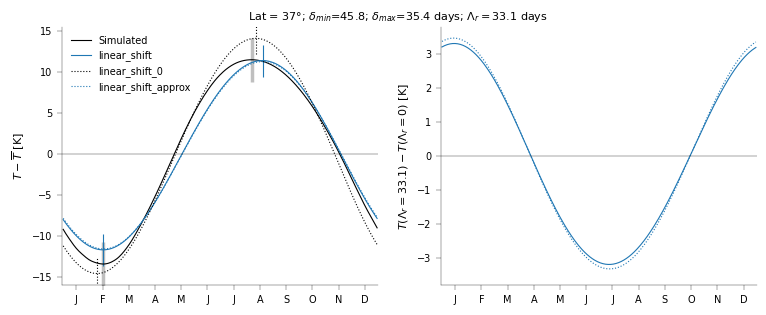

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)

ax[0].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key2 in ['linear_shift', 'linear_shift_0', 'linear_shift_approx']:
    ax[0].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)
    if '0' not in key2:
        ax[1].plot(ds.time, (temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean()) -
                   (temp_approx['linear_shift_0'][plot_lat_ind]-temp_approx['linear_shift_0'][plot_lat_ind].mean()),
                   color=color_approx[key2], linestyle=linestyle_approx[key2])
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    for key2 in ['linear_shift', 'linear_shift_0']:
        ax[0].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500, linestyle=linestyle_approx[key2])
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[1].set_ylabel(f'$T(\Lambda_r={round(lh_rh_cont_params[plot_lat_ind, -1], 1)}) - T(\Lambda_r= 0)$ [K]')
ax[0].legend()
fig.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days; "
             f"$\Lambda_r = {round(lh_rh_cont_params[plot_lat_ind, -1], 1)}$ days", fontsize=8, y=0.93);

### Explicit Effect of $\Lambda_r$
The equation including $\Lambda_r \neq 0$ has a different $\lambda$ parameter to the linear case, so to see the effect of $\Lambda_r$, we need to compare it directly to the same fit, but with $\Lambda_r = 0$.

This is done below. where we again see the later phase and reduced amplitude at low latitudes.

We also see that this is captured by the taylor series calculation using $C_{mod}$ and $\lambda_{mod}$.

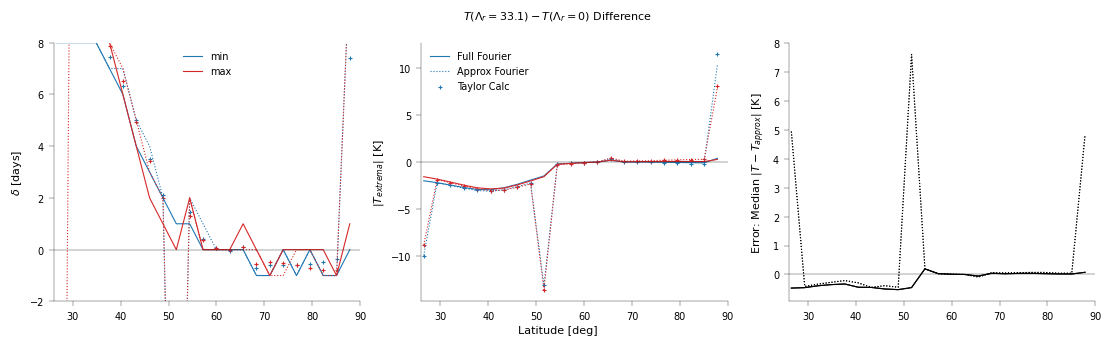

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['linear_shift', 'linear_shift_approx']:
        ax[0].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_temp[key]['linear_shift_0'], 
                   color=color_extrema[key], linestyle=linestyle_approx[key2], label=key if 'approx' not in key2 else None)
        ax[1].plot(ds.lat, amp_extrema_temp[key][key2] - amp_extrema_temp[key]['linear_shift_0'], 
                   color=color_extrema[key], linestyle=linestyle_approx[key2], label=f"{'Approx' if 'approx' in key2 else 'Full'} Fourier" if key=='min' else None)
        ax[2].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key2] - 
                                  np.mean(temp_approx[key2], axis=1)[:, np.newaxis]) - 
                   error_func(smooth_func(t_surf_anom), temp_approx['linear_shift_0'] - 
                                  np.mean(temp_approx['linear_shift_0'], axis=1)[:, np.newaxis]), 
                   color='k', linestyle=linestyle_approx[key2])
    ax[0].scatter(ds.lat, time_extrema_temp[key]['linear_shift_taylor_calc'] - time_extrema_temp[key]['linear_shift_0_taylor_calc'], 
                   color=color_extrema[key], marker='+')
    ax[1].scatter(ds.lat, amp_extrema_temp[key]['linear_shift_taylor_calc'] - amp_extrema_temp[key]['linear_shift_0_taylor_calc'], 
                   color=color_extrema[key], label='Taylor Calc' if key=='min' else None, marker='+')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$\delta$ [days]')
ax[1].set_ylabel('$|T_{extrema}|$ [K]')
ax[2].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_ylim(-2, 8)
fig.supxlabel('Latitude [deg]', fontsize=8)
fig.suptitle(f'$T(\Lambda_r={round(lh_rh_cont_params[plot_lat_ind, -1], 1)}) - T(\Lambda_r= 0)$ Difference', fontsize=8);

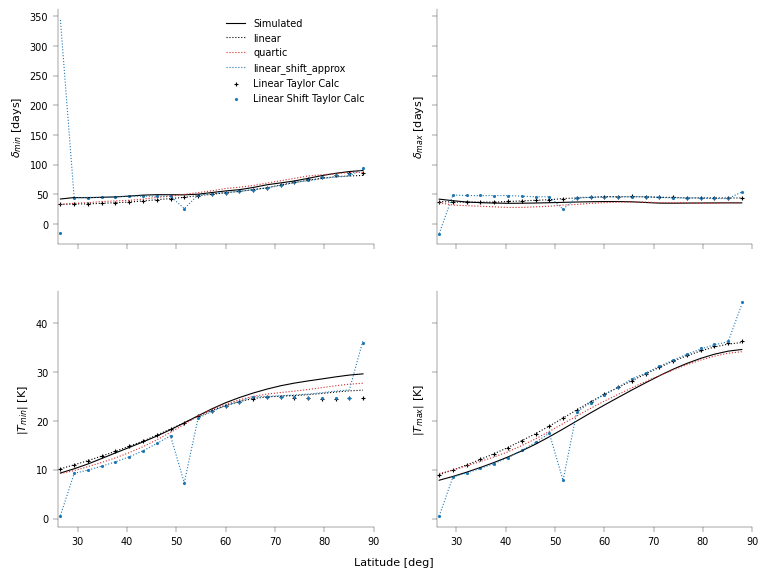

In [25]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['linear', 'quartic', 'linear_shift_approx']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2)
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], 
                     color=color_approx['linear'], marker='+',
                     label='Linear Taylor Calc')
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_shift_taylor_calc'] - time_extrema_sw[key], 
                     color=color_approx['linear_shift'], marker='.',
                     label='Linear Shift Taylor Calc')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_shift_taylor_calc'], color=color_approx['linear_shift'], marker='.')
ax[0, 0].legend()
fig

## Extension beyond 2 Harmonics - Non-linear $\lambda_{sq}T^2$ term in Latent Heat
The latent heat needs a $\lambda_{sq}T^2$ term at high latitudes because latent heat is zero in winter, but temperature is not constant.

This can be included using modified parameters, $C_{mod}$, and $\lambda_{mod}$ for the 2nd harmonic, while using the linear values for the first harmonic. So the squared term only influences the 2nd harmonic.

This is similar to what was done for relative humidity, except that here the $C_{mod}$ and $\lambda_{mod}$ replacement is only for the 2nd harmonic and is exact, hence the approx lines below can't be seen.

In [26]:
gamma_params['square'] = np.zeros((n_lat, 3))     # lambda_0, lambda, lambda_sq
gamma_approx['square'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    gamma_params['square'][i] = optimize.curve_fit(square_func, t_surf[i], gamma_up[i], p0=gamma_params0+[0])[0]
    gamma_approx['square'][i] = square_func(t_surf[i], *gamma_params['square'][i])

temp_approx['square'] = np.zeros((n_lat, n_time))
temp_approx['square_0'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    temp_approx['square'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['square'][i, :2],
                                                lambda_nl=gamma_params['square'][i, 2], single_harmonic_nl=True)[0]
    temp_approx['square_0'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['square'][i, :2])[0]

for key2 in ['square', 'square_0']:
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)

In [27]:
for key2 in ['square_approx']:
    temp_approx[key2] = np.zeros((n_lat, n_time))
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
        time_extrema_temp[key]['square_taylor_calc'] = np.zeros(n_lat)
        amp_extrema_temp[key]['square_taylor_calc'] = np.zeros(n_lat)
        time_extrema_temp[key]['square_0_taylor_calc'] = np.zeros(n_lat)
        amp_extrema_temp[key]['square_0_taylor_calc'] = np.zeros(n_lat)
        
    for i in range(n_lat):
        sq_param = 0.5 * gamma_params['square'][i, 2] * sw_amp_coefs['2'][i, 1]**2 / (gamma_params['square'][i, 1]**2 * sw_amp_coefs['2'][i, 2])
        x_use = 2*np.pi/(360*day_seconds)*heat_capacity/gamma_params['square'][i, 1]
        sq_param = sq_param/(1+x_use**2)**2
        f_beta = 1 - sq_param*(1+4*x_use**2)/(1-sq_param+5*sq_param*x_use**2)
        lambda_const_mod = (1+f_beta*4*x_use**2)/(1+f_beta**2*4*x_use**2)/(1+sq_param*(x_use**2-1)) * gamma_params['square'][i, 1]
        # lambda_const_mod = gamma_params['square'][i, 1] / (1 - sq_param*(3*x_use**2+1))
        heat_capacity_mod = heat_capacity * f_beta * lambda_const_mod / gamma_params['square'][i, 1]
        # 1st harmonic uses normal lambda and heat capacity
        temp_approx[key2][i] = get_temp_fourier(ds.time, sw_fourier_fit['1'][i], heat_capacity, 
                                                gamma_params['square'][i, :2], n_harmonics=1)[0]
        # 2nd harmonic uses modified lambda and heat capacity
        temp_approx[key2][i] += get_temp_fourier(ds.time, fourier.fourier_series(ds.time, 360, [0, 0, sw_amp_coefs['2'][i, 2]], [0, 0]),
                                                heat_capacity_mod, 
                                                np.asarray([0, lambda_const_mod]), n_harmonics=2)[0]
        for key in time_extrema_temp:
            time_extrema_temp[key]['square_taylor_calc'][i], amp_extrema_temp[key]['square_taylor_calc'][i] = \
                get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['square'][i, 1], heat_capacity,
                                            lambda_sq=gamma_params['square'][i, 2],  type=key)[:2]
            time_extrema_temp[key]['square_0_taylor_calc'][i], amp_extrema_temp[key]['square_0_taylor_calc'][i] = \
                get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['square'][i, 1], heat_capacity,  type=key)[:2]

    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)
        
amp_extrema_temp['min']['square_taylor_calc'] = np.abs(amp_extrema_temp['min']['square_taylor_calc'])
amp_extrema_temp['min']['square_0_taylor_calc'] = np.abs(amp_extrema_temp['min']['square_0_taylor_calc'])

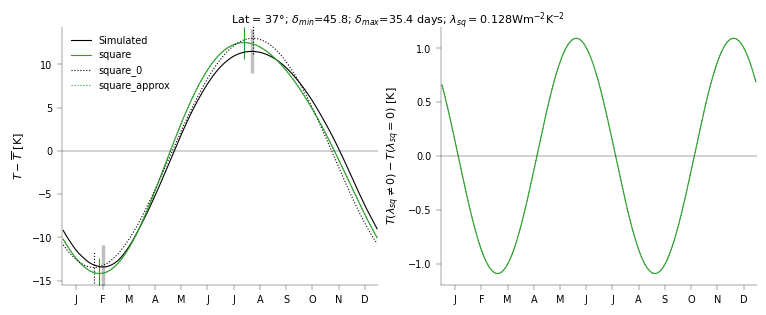

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)

ax[0].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key2 in ['square', 'square_0', 'square_approx']:
    ax[0].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)
    if '0' not in key2:
        ax[1].plot(ds.time, (temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean()) -
                   (temp_approx['square_0'][plot_lat_ind]-temp_approx['square_0'][plot_lat_ind].mean()),
                   color=color_approx[key2], linestyle=linestyle_approx[key2])
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    for key2 in ['square', 'square_0']:
        ax[0].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500, linestyle=linestyle_approx[key2])
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[1].set_ylabel('$T(\lambda_{sq}\\neq 0) - T(\lambda_{sq}= 0)$ [K]')
ax[0].legend()
fig.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days; "
             f"$\lambda_{'{sq}'} = {round(gamma_params['square'][plot_lat_ind, -1], 3)}$Wm$^{'{-2}'}$K$^{'{-2}'}$", fontsize=8, y=0.93);

### Explicit Effect of Squared Term
As with the relative humidity, below we compare the theoretical temperature profile with $\lambda_{sq}\neq 0$ vs $\lambda_{sq}= 0$. We see that the minima gets pushed later in the year, and has higher amplitude. This can probably be explained by the latent heat term being approx 0 in winter with $\lambda_{sq}\neq 0$ vs negative with $\lambda_{sq}= 0$.

It also pulls the maxima earlier in the year, and slightly increases the amplitude.

The taylor series calculation approximation for the amplitude is not great here at high latitudes, but qualtitatively useful.

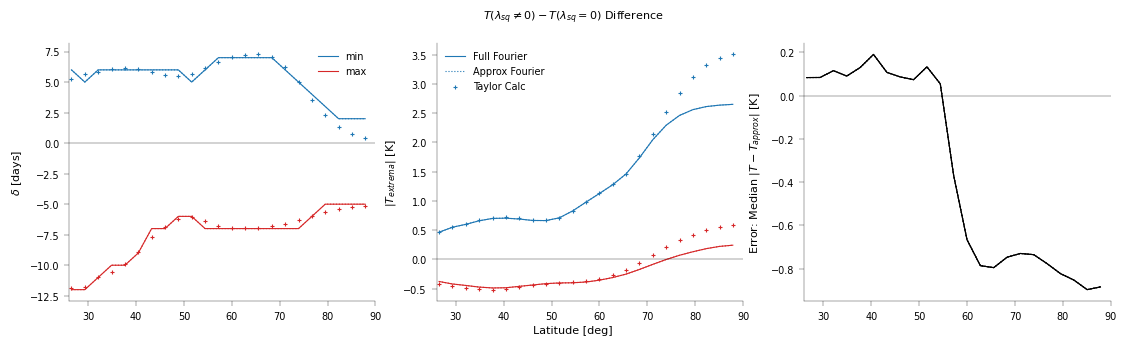

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['square', 'square_approx']:
        ax[0].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_temp[key]['square_0'], 
                   color=color_extrema[key], linestyle=linestyle_approx[key2], label=key if 'approx' not in key2 else None)
        ax[1].plot(ds.lat, amp_extrema_temp[key][key2] - amp_extrema_temp[key]['square_0'], 
                   color=color_extrema[key], linestyle=linestyle_approx[key2], label=f"{'Approx' if 'approx' in key2 else 'Full'} Fourier" if key=='min' else None)
        ax[2].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key2] - 
                                  np.mean(temp_approx[key2], axis=1)[:, np.newaxis]) - 
                   error_func(smooth_func(t_surf_anom), temp_approx['square_0'] - 
                                  np.mean(temp_approx['square_0'], axis=1)[:, np.newaxis]), 
                   color='k', linestyle=linestyle_approx[key2])
    ax[0].scatter(ds.lat, time_extrema_temp[key]['square_taylor_calc'] - time_extrema_temp[key]['square_0_taylor_calc'],
                   color=color_extrema[key], marker='+')
    ax[1].scatter(ds.lat, amp_extrema_temp[key]['square_taylor_calc'] - amp_extrema_temp[key]['square_0_taylor_calc'],
                   color=color_extrema[key], label='Taylor Calc' if key=='min' else None, marker='+')
    # ax[0].scatter(ds.lat, time_extrema_temp[key]['linear_shift_taylor_calc'] - time_extrema_temp[key]['linear_shift_0phase'], 
    #                color=color_extrema[key], marker='+')
    # ax[1].scatter(ds.lat, amp_extrema_temp[key]['linear_shift_taylor_calc'] - amp_extrema_temp[key]['linear_shift_0phase'], 
    #                color=color_extrema[key], label='Taylor Calc' if key=='min' else None, marker='+')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$\delta$ [days]')
ax[1].set_ylabel('$|T_{extrema}|$ [K]')
ax[2].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
# ax[0].set_ylim(-2, 8)
fig.supxlabel('Latitude [deg]', fontsize=8)
fig.suptitle('$T(\lambda_{sq}\\neq 0) - T(\lambda_{sq}= 0)$ Difference', fontsize=8);

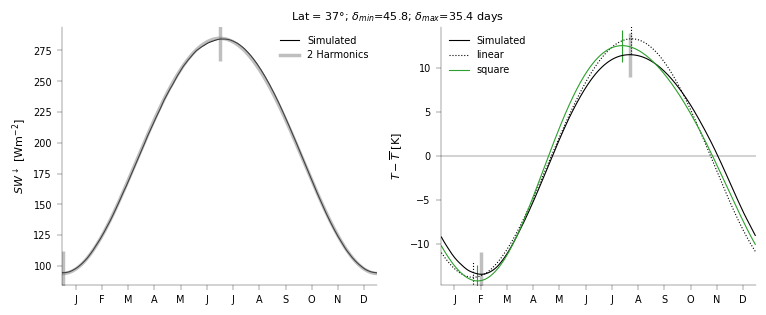

In [30]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
for key2 in ['linear', 'square']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)

for key in time_extrema_sw:
    for key2 in ['linear', 'square']:
        ax[1].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500, linestyle=linestyle_approx[key2])
ax[0].legend()
ax[1].legend()
fig

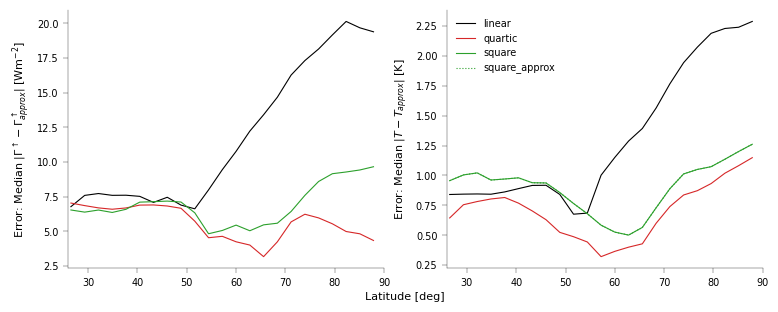

In [31]:
fig = copy.deepcopy(fig_error)
ax = fig.axes
for key in ['linear', 'quartic', 'square', 'square_approx']:
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key] - 
                                  np.mean(temp_approx[key], axis=1)[:, np.newaxis]), color=color_approx[key], 
               label=key, linestyle=linestyle_approx[key] if 'approx' in key else None)
ax[0].plot(ds.lat, error_func(smooth_func(gamma_up), gamma_approx['square']), color=color_approx['square'], 
               label=key if key != 'linear' else '2_harmonic')

ax[1].legend()
ax[0].get_legend().remove()
fig

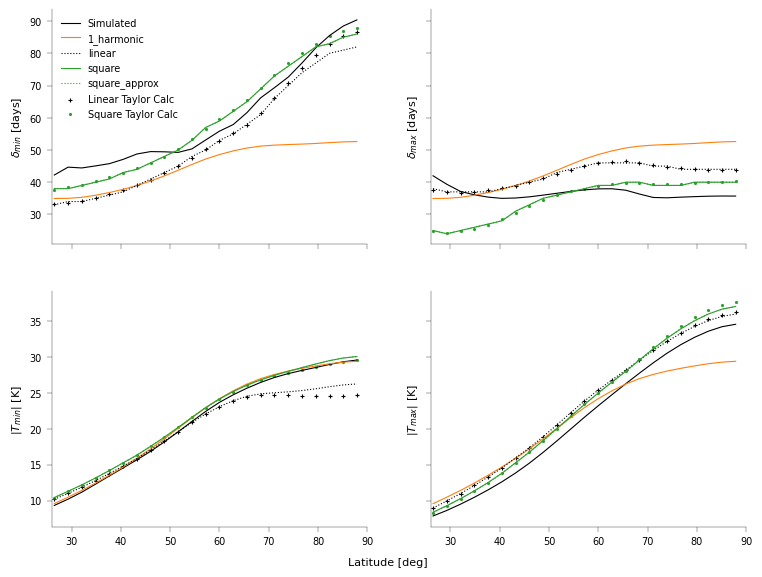

In [32]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    # for key2 in ['linear', 'quartic', 'square', 'square_approx']:
    for key2 in ['1_harmonic', 'linear', 'square', 'square_approx']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2)
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], 
                     color=color_approx['linear'], marker='+',
                     label='Linear Taylor Calc')
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['square_taylor_calc'] - time_extrema_sw[key], 
                     color=color_approx['square'], marker='.',
                     label='Square Taylor Calc')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['square_taylor_calc'], color=color_approx['square'], marker='.')
ax[0, 0].legend()
fig

## Final Approximation
Above, we have seen that the relative humidity phasing is useful at low latitudes, and the squared term is useful at high latitudes. Below, we combine these to give a final approximation for $\Gamma$ and thus $T(t)$.

This is just combining plots we have already seen - uses `linear_shift` at low latitudes, and `square` at high latitudes. There is nevery a latitude where both are used.

In [33]:
def true_cluster_ind(bool_array):
    # Returns indices of clusters of neighbouring True values, and size of each cluster
    true_ranges = np.argwhere(np.diff(bool_array,prepend=False,append=False))
    true_ranges = true_ranges.reshape(len(true_ranges)//2,2)
    true_ranges = [np.arange(r[0], r[1]) for r in true_ranges]
    cluster_size = np.asarray([len(true_ranges[i]) for i in range(len(true_ranges))])
    return true_ranges, cluster_size

error_thresh = 2            # Need non-linear effect to be better than linear fit by more than 2W/m^2 in both median and max error
min_cluster_size = 4        # Need non-linear effect to be beneficial over lat range of 4 or more values to keep
ind_gamma_shift = np.logical_or(*[error_func_dict[key](gamma_up, gamma_approx['linear']) -
                                  error_func_dict[key](gamma_up, gamma_approx['linear_shift']) > error_thresh for key in ['median', 'max']])
if np.sum(ind_gamma_shift)>0:
    ind_gamma_shift, cluster_size = true_cluster_ind(ind_gamma_shift)
    ind_gamma_shift = np.concatenate([ind_gamma_shift[i] for i in np.argwhere(cluster_size>=min_cluster_size).flatten()])

ind_gamma_square = np.logical_or(*[error_func_dict[key](gamma_up, gamma_approx['linear']) -
                                   error_func_dict[key](gamma_up, gamma_approx['square']) > error_thresh for key in ['median', 'max']])
ind_gamma_square, cluster_size = true_cluster_ind(ind_gamma_square)
ind_gamma_square = np.concatenate([ind_gamma_square[i] for i in np.argwhere(cluster_size>=min_cluster_size).flatten()])


gamma_params['final'] = np.zeros((n_lat, 5))     # lambda_0, lambda, lambda_r, Lambda_r, lambda_sq
gamma_params['final'][:, :2] = gamma_params['linear']
gamma_params['final'][ind_gamma_shift, :4] = gamma_params['linear_shift'][ind_gamma_shift]
gamma_params['final'][ind_gamma_square, :2] = gamma_params['square'][ind_gamma_square, :2]
gamma_params['final'][ind_gamma_square, -1] = gamma_params['square'][ind_gamma_square, -1]

gamma_approx['final'] = copy.deepcopy(gamma_approx['linear'])
gamma_approx['final'][ind_gamma_shift] = gamma_approx['linear_shift'][ind_gamma_shift]
gamma_approx['final'][ind_gamma_square] = gamma_approx['square'][ind_gamma_square]

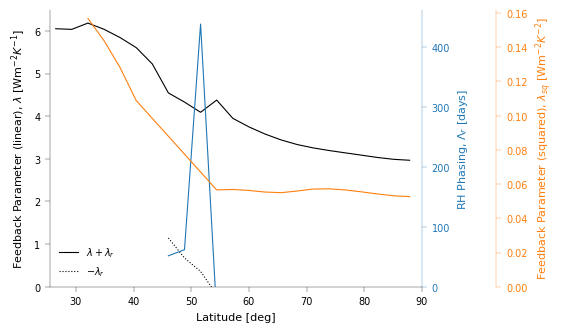

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
ax = [ax, ax.twinx(), ax.twinx()]
ax[2].spines.right.set_position(("axes", 1.2))

ax[0].plot(ds.lat, gamma_params['final'][:, 1]+gamma_params['final'][:, 2], color='k', label='$\lambda + \lambda_r$')
ax[0].plot(ds.lat[ind_gamma_shift], -gamma_params['final'][ind_gamma_shift, 2], color='k', linestyle=':', label='$-\lambda_r$')
ax[1].plot(ds.lat[ind_gamma_shift], gamma_params['final'][ind_gamma_shift, 3], color=default_colors[0])
ax[2].plot(ds.lat[ind_gamma_square], gamma_params['final'][ind_gamma_square, 4], color=default_colors[1])

for i in range(len(ax)):
    ax[i].set_ylim(0, ax[i].get_ylim()[1])
    if i==0: continue
    ax[i].spines[['bottom', 'left']].set_visible(False)
    ax[i].spines[['right']].set_visible(True)
    ax[i].spines.right.set_color(default_colors[i-1])
    ax[i].tick_params(axis='y', colors=default_colors[i-1])

ax[0].legend(loc='lower left')
ax[0].set_xlim(ds.lat[0]-1, 90)
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Feedback Parameter (linear), $\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('RH Phasing, $\Lambda_r$ [days]', color=default_colors[0])
ax[2].set_ylabel('Feedback Parameter (squared), $\lambda_{sq}$ [Wm$^{-2}K^{-2}$]', color=default_colors[1]);

In [35]:
temp_approx['final'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    temp_approx['final'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['final'][i, :3],
                                               lambda_time_lag=np.asarray([0, gamma_params['final'][i, 3]]), 
                                               lambda_nl=gamma_params['final'][i, -1], single_harmonic_nl=True)[0]

for key2 in ['final']:
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)
    
    
for key in time_extrema_temp:
    time_extrema_temp[key]['final_taylor_calc'] = copy.deepcopy(time_extrema_temp[key]['linear_taylor_calc'])
    time_extrema_temp[key]['final_taylor_calc'][ind_gamma_shift] = time_extrema_temp[key]['linear_shift_taylor_calc'][ind_gamma_shift]
    time_extrema_temp[key]['final_taylor_calc'][ind_gamma_square] = time_extrema_temp[key]['square_taylor_calc'][ind_gamma_square]
    
    amp_extrema_temp[key]['final_taylor_calc'] = copy.deepcopy(amp_extrema_temp[key]['linear_taylor_calc'])
    amp_extrema_temp[key]['final_taylor_calc'][ind_gamma_shift] = amp_extrema_temp[key]['linear_shift_taylor_calc'][ind_gamma_shift]
    amp_extrema_temp[key]['final_taylor_calc'][ind_gamma_square] = amp_extrema_temp[key]['square_taylor_calc'][ind_gamma_square]

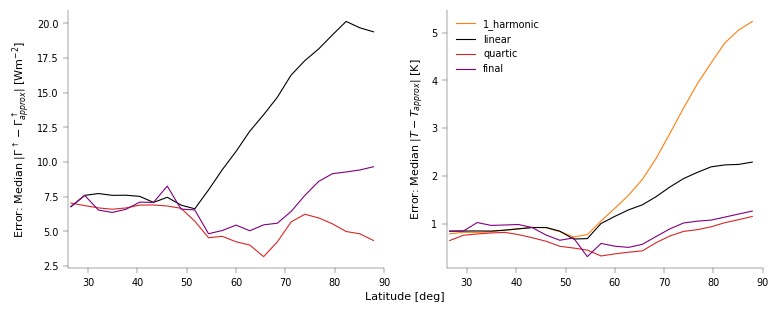

In [36]:
fig = copy.deepcopy(fig_error)
ax = fig.axes
for key in ['1_harmonic', 'linear', 'quartic', 'final']:
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key] - 
                                  np.mean(temp_approx[key], axis=1)[:, np.newaxis]), color=color_approx[key], 
               label=key, linestyle=linestyle_approx[key] if 'approx' in key else None)
ax[0].plot(ds.lat, error_func(smooth_func(gamma_up), gamma_approx['final']), color=color_approx['final'], 
               label=key if key != 'linear' else '2_harmonic')

ax[1].legend()
ax[0].get_legend().remove()
fig

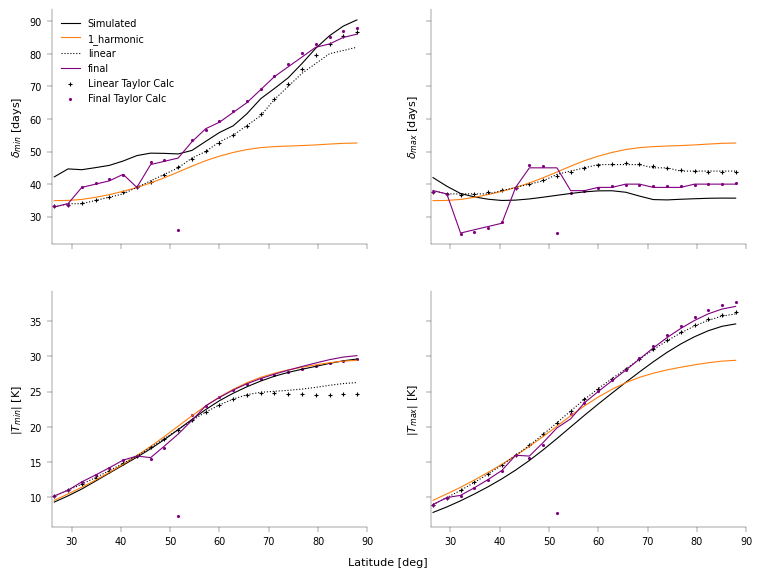

In [37]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear', 'final']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2)
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], 
                     color=color_approx['linear'], marker='+',
                     label='Linear Taylor Calc')
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['final_taylor_calc'] - time_extrema_sw[key], 
                     color=color_approx['final'], marker='.',
                     label='Final Taylor Calc')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['final_taylor_calc'], color=color_approx['final'], marker='.')
ax[0, 0].legend()
fig

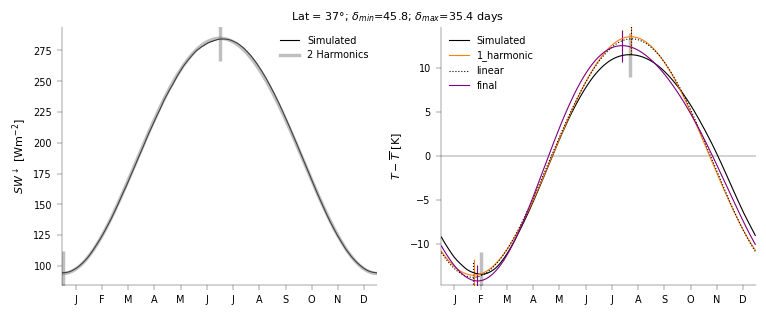

In [38]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
for key2 in ['1_harmonic', 'linear', 'final']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)

for key in time_extrema_sw:
    for key2 in ['1_harmonic', 'linear', 'final']:
        ax[1].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500, linestyle=linestyle_approx[key2])
ax[0].legend()
ax[1].legend()
fig

## Linear Case dependence of hottest day on $F_2/F_1$ and $C/\lambda$
If we write $t_{max} = t_{max1} + \Delta$ and $|T_{max}| = A|T_{max1}|$, where $2 \pi ft_{max1} = \arctan(\frac{2\pi fC}{\lambda})$ and $T_{max1} = \frac{F_1}{\lambda \sqrt{1+(\frac{2\pi fC}{\lambda})^2}}$ are the timings and amplitude of the 1st harmonic, then both $\Delta$ and $A$ only depend on $C/\lambda$ and $F_2/F_1$ in the linear case. This dependence is plotted below.

The $\lambda$ factor decreases and $F_2/F_1$ becomes more negative as we move to the north pole, so the bottom right of the plots represents the north pole.

In [39]:
def get_lambda_from_x(x, heat_capacity=heat_capacity, f=1/360, day_seconds=day_seconds):
    return 2*np.pi*f/day_seconds*heat_capacity/x

x_array = np.linspace(0.9, 1.55, 66)
sw_amp_ratio_array = np.linspace(-0.5, 0.25, 76)
sw_amp1_use = -100       # typical negative value to reflect northern hemisphere

extrema_array_info = {key2: {key: np.zeros((len(x_array), len(sw_amp_ratio_array))) for key in ['time_mod', 'amp_scale']} for key2 in ['min', 'max']}
for i in range(len(x_array)):
    for j in range(len(sw_amp_ratio_array)):
        for key in extrema_array_info:
            info_use = get_extrema_amp_time_approx(sw_amp1_use, sw_amp_ratio_array[j]*sw_amp1_use, 
                                       get_lambda_from_x(x_array[i], heat_capacity), heat_capacity, type=key)[2]
            extrema_array_info[key]['time_mod'][i, j] = info_use['t_extrema_mod']
            extrema_array_info[key]['amp_scale'][i, j] = info_use['amp_extrema_scale']

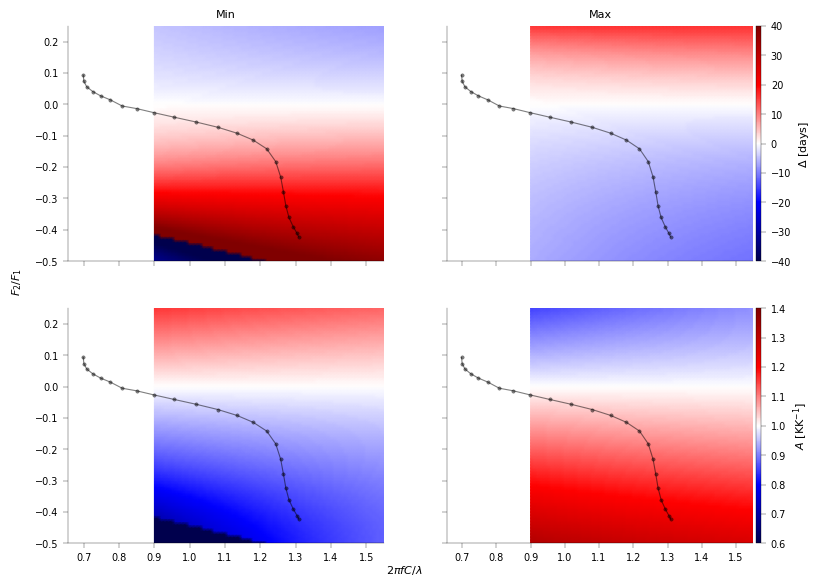

In [40]:
sw_amp_ratio_lat = sw_amp_coefs['2'][:, 2]/sw_amp_coefs['2'][:, 1]

fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey=True)
for i, key in enumerate(extrema_array_info):
    im1 = ax[0, i].pcolormesh(x_array, sw_amp_ratio_array, extrema_array_info[key]['time_mod'].transpose(), vmin=-40, vmax=40, 
                        cmap='seismic', shading='gouraud')
    im2 = ax[1, i].pcolormesh(x_array, sw_amp_ratio_array, extrema_array_info[key]['amp_scale'].transpose(), vmin=0.6, vmax=1.4, 
                        cmap='seismic', shading='gouraud')
    for j in range(2):
        ax[j, i].plot(get_x_from_lambda(gamma_params['linear'][:,1]), sw_amp_ratio_lat, 
                      color='k', marker='o', alpha=0.5)
    ax[0, i].set_title(key.capitalize())
plt.colorbar(im1, ax=ax[0, 1], aspect=50, pad=0.01, fraction=0.02, label='$\Delta$ [days]')
plt.colorbar(im2, ax=ax[1, 1], aspect=50, pad=0.01, fraction=0.02, label='$A$ [KK$^{-1}$]')
fig.supylabel('$F_2/F_1$', fontsize=8, x=0.06)
fig.supxlabel('$2\pi fC/\lambda$', fontsize=8, y=0.06);

### Split Variation with latitude into contributions
Below we see that the value of $\lambda$ has very little influence on the phase and amplitude of hottest and coldest days relative to the first harmonic.

In [41]:
# Use spline so can get partial differential function
ind_ref_lat = int(np.floor(n_lat/2))        # reference latitude is mid-latitude in range we are using
extrema_array_info_breakdown = {key2: {key: {key3: np.zeros(n_lat) for key3 in 
                                             ['sw_amp_ratio', 'lambda', 'non_linear']} 
                                       for key in ['time_mod', 'amp_scale']} for key2 in ['min', 'max']}
# Get contribution from each parameter, by changing that parameter and leaving other at a reference.
for key in ['min', 'max']:
    for key2 in ['time_mod', 'amp_scale']:
        spline_use = scipy.interpolate.RectBivariateSpline(x_array, sw_amp_ratio_array, extrema_array_info[key][key2])
        var_ref = spline_use(get_x_from_lambda(gamma_params['linear'][ind_ref_lat,1]), sw_amp_ratio_lat[ind_ref_lat])[0, 0]
        for key3 in ['sw_amp_ratio', 'lambda', 'non_linear']:
            for i in range(n_lat):
                extrema_array_info_breakdown[key][key2]['lambda'][i] = spline_use(get_x_from_lambda(gamma_params['linear'][i,1]), 
                                                                               sw_amp_ratio_lat[ind_ref_lat])[0, 0] - var_ref
                extrema_array_info_breakdown[key][key2]['sw_amp_ratio'][i] = spline_use(get_x_from_lambda(gamma_params['linear'][ind_ref_lat, 1]), 
                                                                               sw_amp_ratio_lat[i])[0, 0] - var_ref
                extrema_array_info_breakdown[key][key2]['non_linear'][i] = \
                    spline_use(get_x_from_lambda(gamma_params['linear'][i,1]), sw_amp_ratio_lat[i])[0, 0] - var_ref - \
                    extrema_array_info_breakdown[key][key2]['lambda'][i] - extrema_array_info_breakdown[key][key2]['sw_amp_ratio'][i]

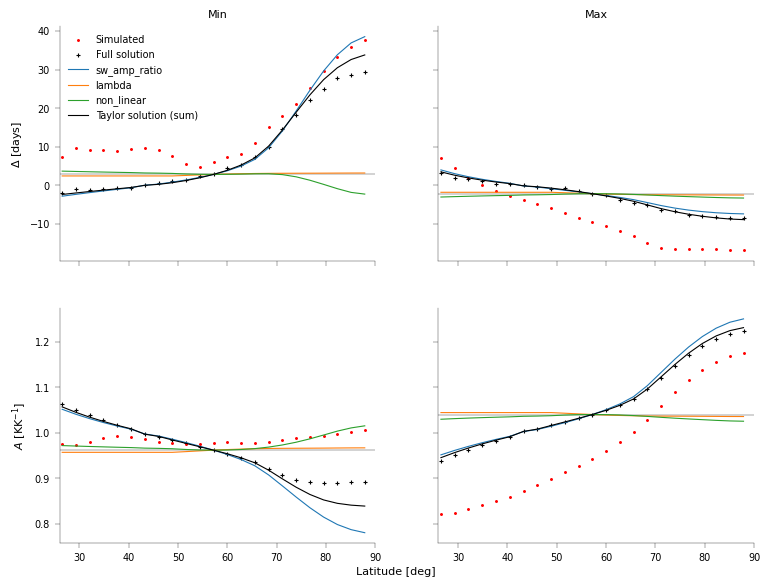

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(extrema_array_info):
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['simulated'] - time_extrema_temp[key]['1_harmonic'], 
                     color='r', marker='.', label='Simulated', s=5)
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear'] - time_extrema_temp[key]['1_harmonic'], 
                     color='k', marker='+', label='Full solution', s=5)
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear'] / amp_extrema_temp[key]['1_harmonic'] 
                     , color='k', marker='+', s=5)
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['simulated'] / amp_extrema_temp[key]['1_harmonic'] 
                     , color='r', marker='.', s=5)
    ax[0, i].set_title(key.capitalize())
    for j, key2 in enumerate(extrema_array_info_breakdown[key]):
        if j==0:
            var_ref = (time_extrema_temp[key]['linear'] - time_extrema_temp[key]['1_harmonic'])[ind_ref_lat]
        else:
            var_ref = (amp_extrema_temp[key]['linear'] / amp_extrema_temp[key]['1_harmonic'])[ind_ref_lat]
        ax[j, i].axhline(var_ref, color='k', lw=ax_linewidth)
        for k, key3 in enumerate(['sw_amp_ratio', 'lambda', 'non_linear']):
            ax[j, i].plot(ds.lat, extrema_array_info_breakdown[key][key2][key3]+var_ref, color=default_colors[k], label=key3)
        ax[j, i].plot(ds.lat, sum(extrema_array_info_breakdown[key][key2].values())+var_ref, color='k', label='Taylor solution (sum)')
ax[0, 0].legend()
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylabel('$\Delta$ [days]')
ax[1, 0].set_ylabel('$A$ [KK$^{-1}$]')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.06);

### 1st Harmonic Variation
Below, we see that the variation of $\lambda$ with latitude is important for the amplitude, and especially the phase of the 1st harmonic. So it seems we can split up the effect of $\lambda$ and $F_2/F_1$. $\lambda$ influences the 1st harmonic, and then $F_2/F_1$ influences how much the 2nd harmonic causes the actual extrema to differ from the 1st harmonic.

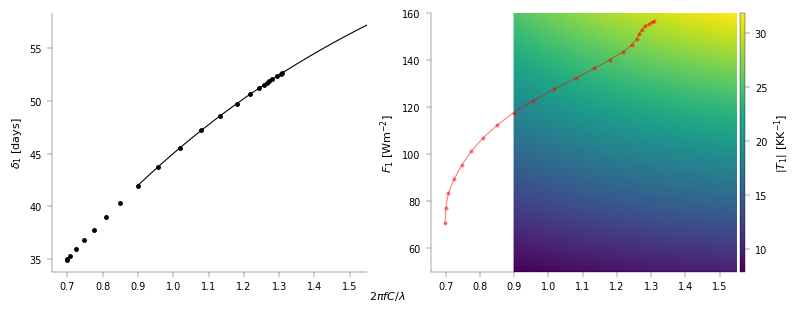

In [43]:
sw_amp1_array = np.linspace(50, 160, 111)
amp_1_harmonic_extrema_array = sw_amp1_array[np.newaxis]/get_lambda_from_x(x_array[:, np.newaxis], heat_capacity)/np.sqrt(1+x_array[:, np.newaxis]**2)

fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(x_array, np.arctan(x_array)/2/np.pi*360-time_extrema_sw['min'], color='k')
ax[0].scatter(get_x_from_lambda(gamma_params['linear'][:, 1]), time_extrema_temp['min']['1_harmonic'], color='k', marker='o')
im = ax[1].pcolormesh(x_array, sw_amp1_array, amp_1_harmonic_extrema_array.T, shading='gouraud')
plt.colorbar(im, ax=ax[1], aspect=50, pad=0.01, fraction=0.02, label='$|T_1|$ [KK$^{-1}$]')
ax[1].plot(get_x_from_lambda(gamma_params['linear'][:,1]), np.abs(sw_amp_coefs['1'][:, 1]), 
           color='r', marker='o', alpha=0.5)
ax[0].set_ylabel('$\delta_1$ [days]')
ax[1].set_ylabel('$F_1$ [Wm$^{-2}$]')
fig.supxlabel('$2\pi fC/\lambda$', fontsize=8, y=0.02);

In [44]:
spline_use = scipy.interpolate.RectBivariateSpline(x_array, sw_amp1_array, amp_1_harmonic_extrema_array)
amp_1_harmonic_extrema_array_breakdown = {key: np.zeros(n_lat) for key in ['sw_amp1', 'lambda', 'non_linear']}
var_ref = np.abs(amp_extrema_temp['min']['1_harmonic'][ind_ref_lat])
for i in range(n_lat):
    amp_1_harmonic_extrema_array_breakdown['lambda'][i] = spline_use(get_x_from_lambda(gamma_params['linear'][i,1]), 
                                                                   np.abs(sw_amp_coefs['1'][ind_ref_lat, 1]))[0, 0] - var_ref
    amp_1_harmonic_extrema_array_breakdown['sw_amp1'][i] = spline_use(get_x_from_lambda(gamma_params['linear'][ind_ref_lat, 1]), 
                                                                   np.abs(sw_amp_coefs['1'][i, 1]))[0, 0] - var_ref
amp_1_harmonic_extrema_array_breakdown['non_linear'] = \
    np.abs(amp_extrema_temp['min']['1_harmonic']) - var_ref - amp_1_harmonic_extrema_array_breakdown['lambda'] - \
    amp_1_harmonic_extrema_array_breakdown['sw_amp1']

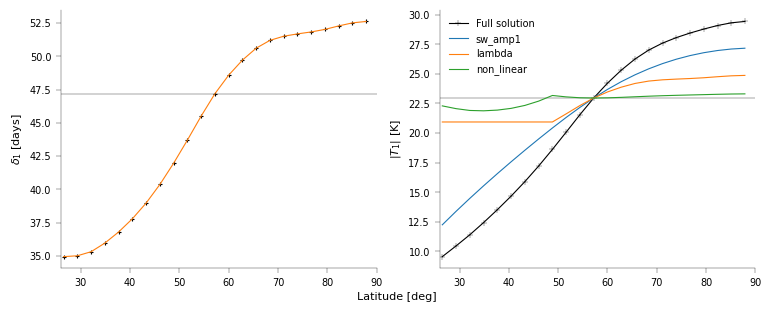

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.lat, time_extrema_temp['min']['1_harmonic']-time_extrema_sw['min'], color=default_colors[1])
ax[0].scatter(ds.lat, time_extrema_temp['min']['1_harmonic']-time_extrema_sw['min'], marker='+', color='k', s=5)
ax[1].plot(ds.lat, np.abs(amp_extrema_temp['min']['1_harmonic']), color='k', marker='+', label='Full solution', markersize=5)
for j in range(2):
    if j==0:
        var_ref = time_extrema_temp['min']['1_harmonic'][ind_ref_lat]
    else:
        var_ref = np.abs(amp_extrema_temp['min']['1_harmonic'][ind_ref_lat])
    ax[j].axhline(var_ref, color='k', lw=ax_linewidth)
for key in amp_1_harmonic_extrema_array_breakdown:
    ax[1].plot(ds.lat, amp_1_harmonic_extrema_array_breakdown[key]+var_ref, label=key)
ax[1].legend()
ax[0].set_xlim(ax_lims_lat)
ax[0].set_ylabel('$\delta_1$ [days]')
ax[1].set_ylabel('$|T_1|$ [K]')
fig.supxlabel('Latitude [deg]', fontsize=8, y=0.01);

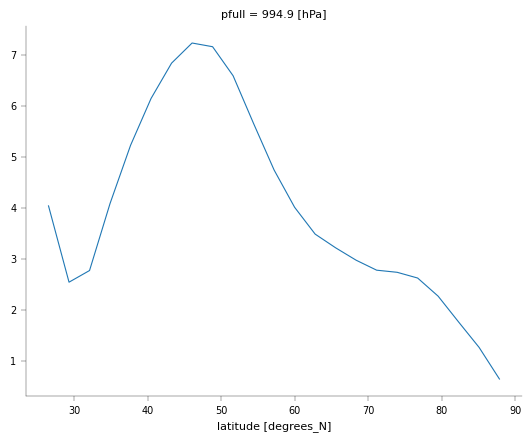

In [46]:
np.sqrt(ds.ucomp**2+ds.vcomp**2).mean(dim='time').plot()